In [1]:
import os
from typing import Literal, Annotated
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent
from langchain_experimental.utilities import PythonREPL

In [2]:
load_dotenv()

True

In [3]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
LANGSMITH_TRACING="true"
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY= os.getenv("LANGSMITH_API_KEY")

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Llama3-8b-8192")

In [6]:
llm.invoke("hi")

AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.020833333, 'prompt_time': 0.002391419, 'queue_time': 0.24467557099999998, 'total_time': 0.023224752}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run--1d43cf55-6b33-4b1d-a659-9a2000e8f94f-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})

In [7]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""

In [8]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""

In [9]:
def addition_expert(state:MessagesState) -> Command[Literal["multiplication_expert","__end__"]]:
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    messages = [{"role":"system","content":system_prompt}] + state["messages"]
    ai_msg = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role":"tool",
            "content":"Successfully transferred",
            "tool_call_id": tool_call_id
        }
        return Command(
            goto="multiplication_expert", update = {"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [10]:
def multiplication_expert(state:MessagesState) -> Command[Literal["addition_expert","__end__"]]:
    system_prompt = (
        "You are an multiplication expert, you can ask an addition expert for help with addition."
        "Always do your portion of calculation before the handoff."
    )
    messages = [{"role":"system","content":system_prompt}] + state["messages"]
    ai_msg = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role":"tool",
            "content":"Successfully transferred",
            "tool_call_id": tool_call_id
        }
        return Command(
            goto="addition_expert", update = {"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [11]:
graph = StateGraph(MessagesState)
graph.add_node("addition_expert",addition_expert)
graph.add_node("multiplication_expert",multiplication_expert)
graph.add_edge(START,"addition_expert")
app = graph.compile()

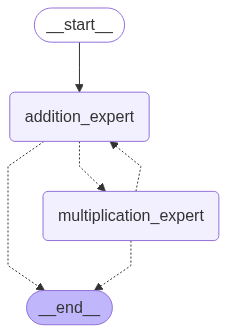

In [12]:
display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='0da06533-4c9f-483a-b728-fb9a904a76f4'),
  AIMessage(content='To calculate this, I\'ll start by adding 3 and 5, which gives me 8. Then, I\'ll multiply 8 by 12, which gives me 96.\n\n<tool-use>\n{\n\t"tool_calls": []\n}\n</tool-use>\n\nThe answer is 96.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 890, 'total_tokens': 951, 'completion_time': 0.050833333, 'prompt_time': 0.110777454, 'queue_time': 0.24905079200000002, 'total_time': 0.161610787}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'stop', 'logprobs': None}, id='run--79ab096d-3b63-4ab8-bad4-a8d920b1a68f-0', usage_metadata={'input_tokens': 890, 'output_tokens': 61, 'total_tokens': 951})]}

In [14]:
from langchain_core.messages import convert_to_messages
def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        if len(ns) == 0:
            return
        
        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        
    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")
        
        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [15]:
for chunk in app.stream({"messages":[("user", "what's (3 + 5) * 12. Provide me the output.")]}):
    print("****chunk...****")
    pretty_print_messages(chunk)

****chunk...****
Update from node addition_expert:


================================== Ai Message ==================================

I can handle this calculation!

First, I'll calculate the addition part: 3 + 5 = 8

Now, I'll multiply the result by 12: 8 * 12 = 96

So, the final answer is: 96




In [17]:
@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    return

@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return

In [18]:
def travel_advisor(state:MessagesState) -> Command[Literal["hotel_advisor","__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend traevl destinations (e.g. countries, cities, etc)."
        "If you need hotel recommendations, ask 'hotel_advisor' for help."
    )
    messages = [{"role":"system", "content": system_prompt}] + state["messages"]
    ai_msg = llm.bind_tools([transfer_to_hotel_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages":[ai_msg]}

In [19]:
def hotel_advisor(state: MessagesState) -> Command[Literal["travel_advisor","__end__"]]:
    system_prompt = (
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
    )
    messages = [{"role":"system", "content": system_prompt}] + state["messages"]
    ai_msg = llm.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [20]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("travel_advisor", travel_advisor)
graph_builder.add_node("hotel_advisor", hotel_advisor)
graph_builder.add_edge(START,"travel_advisor")
app1 = graph_builder.compile()

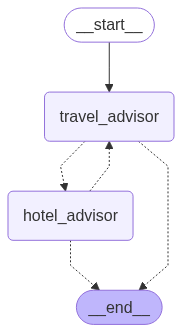

In [21]:
display(Image(app1.get_graph().draw_mermaid_png()))

In [22]:
for chunk in app1.stream({"messages":[("user", "I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?")]}):
    print("****chunk...****")
    pretty_print_messages(chunk)

****chunk...****
Update from node travel_advisor:


================================== Ai Message ==================================

California is a beautiful state with a diverse range of landscapes, cultures, and attractions. As you're planning your trip from Mumbai, I'll guide you through the travel options and suggest a few hotels.

To get to California from Mumbai, you have several options:

1. Fly: The fastest and most convenient way to reach California is by flying. You can take a connecting flight from Mumbai to Los Angeles (LAX) or San Francisco (SFO) with airlines like Emirates, Qatar Airways, or Air India. The total travel time would be around 20 hours, depending on the layovers.
2. Cruise: If you prefer a slower pace and enjoy the ocean, you can take a cruise from Mumbai to the West Coast of the United States. This option would take around 30-40 days, depending on the route and type of cruise.
3. Drive: If you're adventurous and have a lot of time, you can drive from Mumba